In [48]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import math 

In [49]:
code='NIFTY_BANK.csv'
df=pd.read_csv(code)
df.rename(columns={'Date ':'Date','Open ':'Open','High ':'High','Low ':'Low','Close ':'Close'},inplace=True)
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close'], dtype='object')

In [50]:
dt=df
dt.set_index('Date',inplace=True)
dt.index=pd.to_datetime(dt.index,format="%d/%m/%y").date
dt=round(dt,2)

In [51]:
dt.tail()

,Open,High,Low,Close
2024-01-04,47805.40,48281.20,47738.15,48195.85
2024-01-05,48245.55,48381.95,47822.85,48159.00
2024-01-08,48096.65,48154.50,47387.35,47450.25
2024-01-09,47705.40,47939.30,47156.05,47242.65
2024-01-10,47073.85,47423.45,47010.80,47360.85


In [52]:
#Stop Loss
def long_stop(long_price,system_low):
    system_points=long_price - system_low
    
    if  long_price*0.02 < system_points:
        stop_price=round(long_price*0.98,2)
    else:
        stop_price=system_low
    
    return stop_price

def short_stop(short_price,system_high):
    system_points=system_high - short_price
    
    if short_price*0.02 < system_points:
        stop_price=round(short_price*1.02,2)
    else:
        stop_price=system_high 
    
    return stop_price

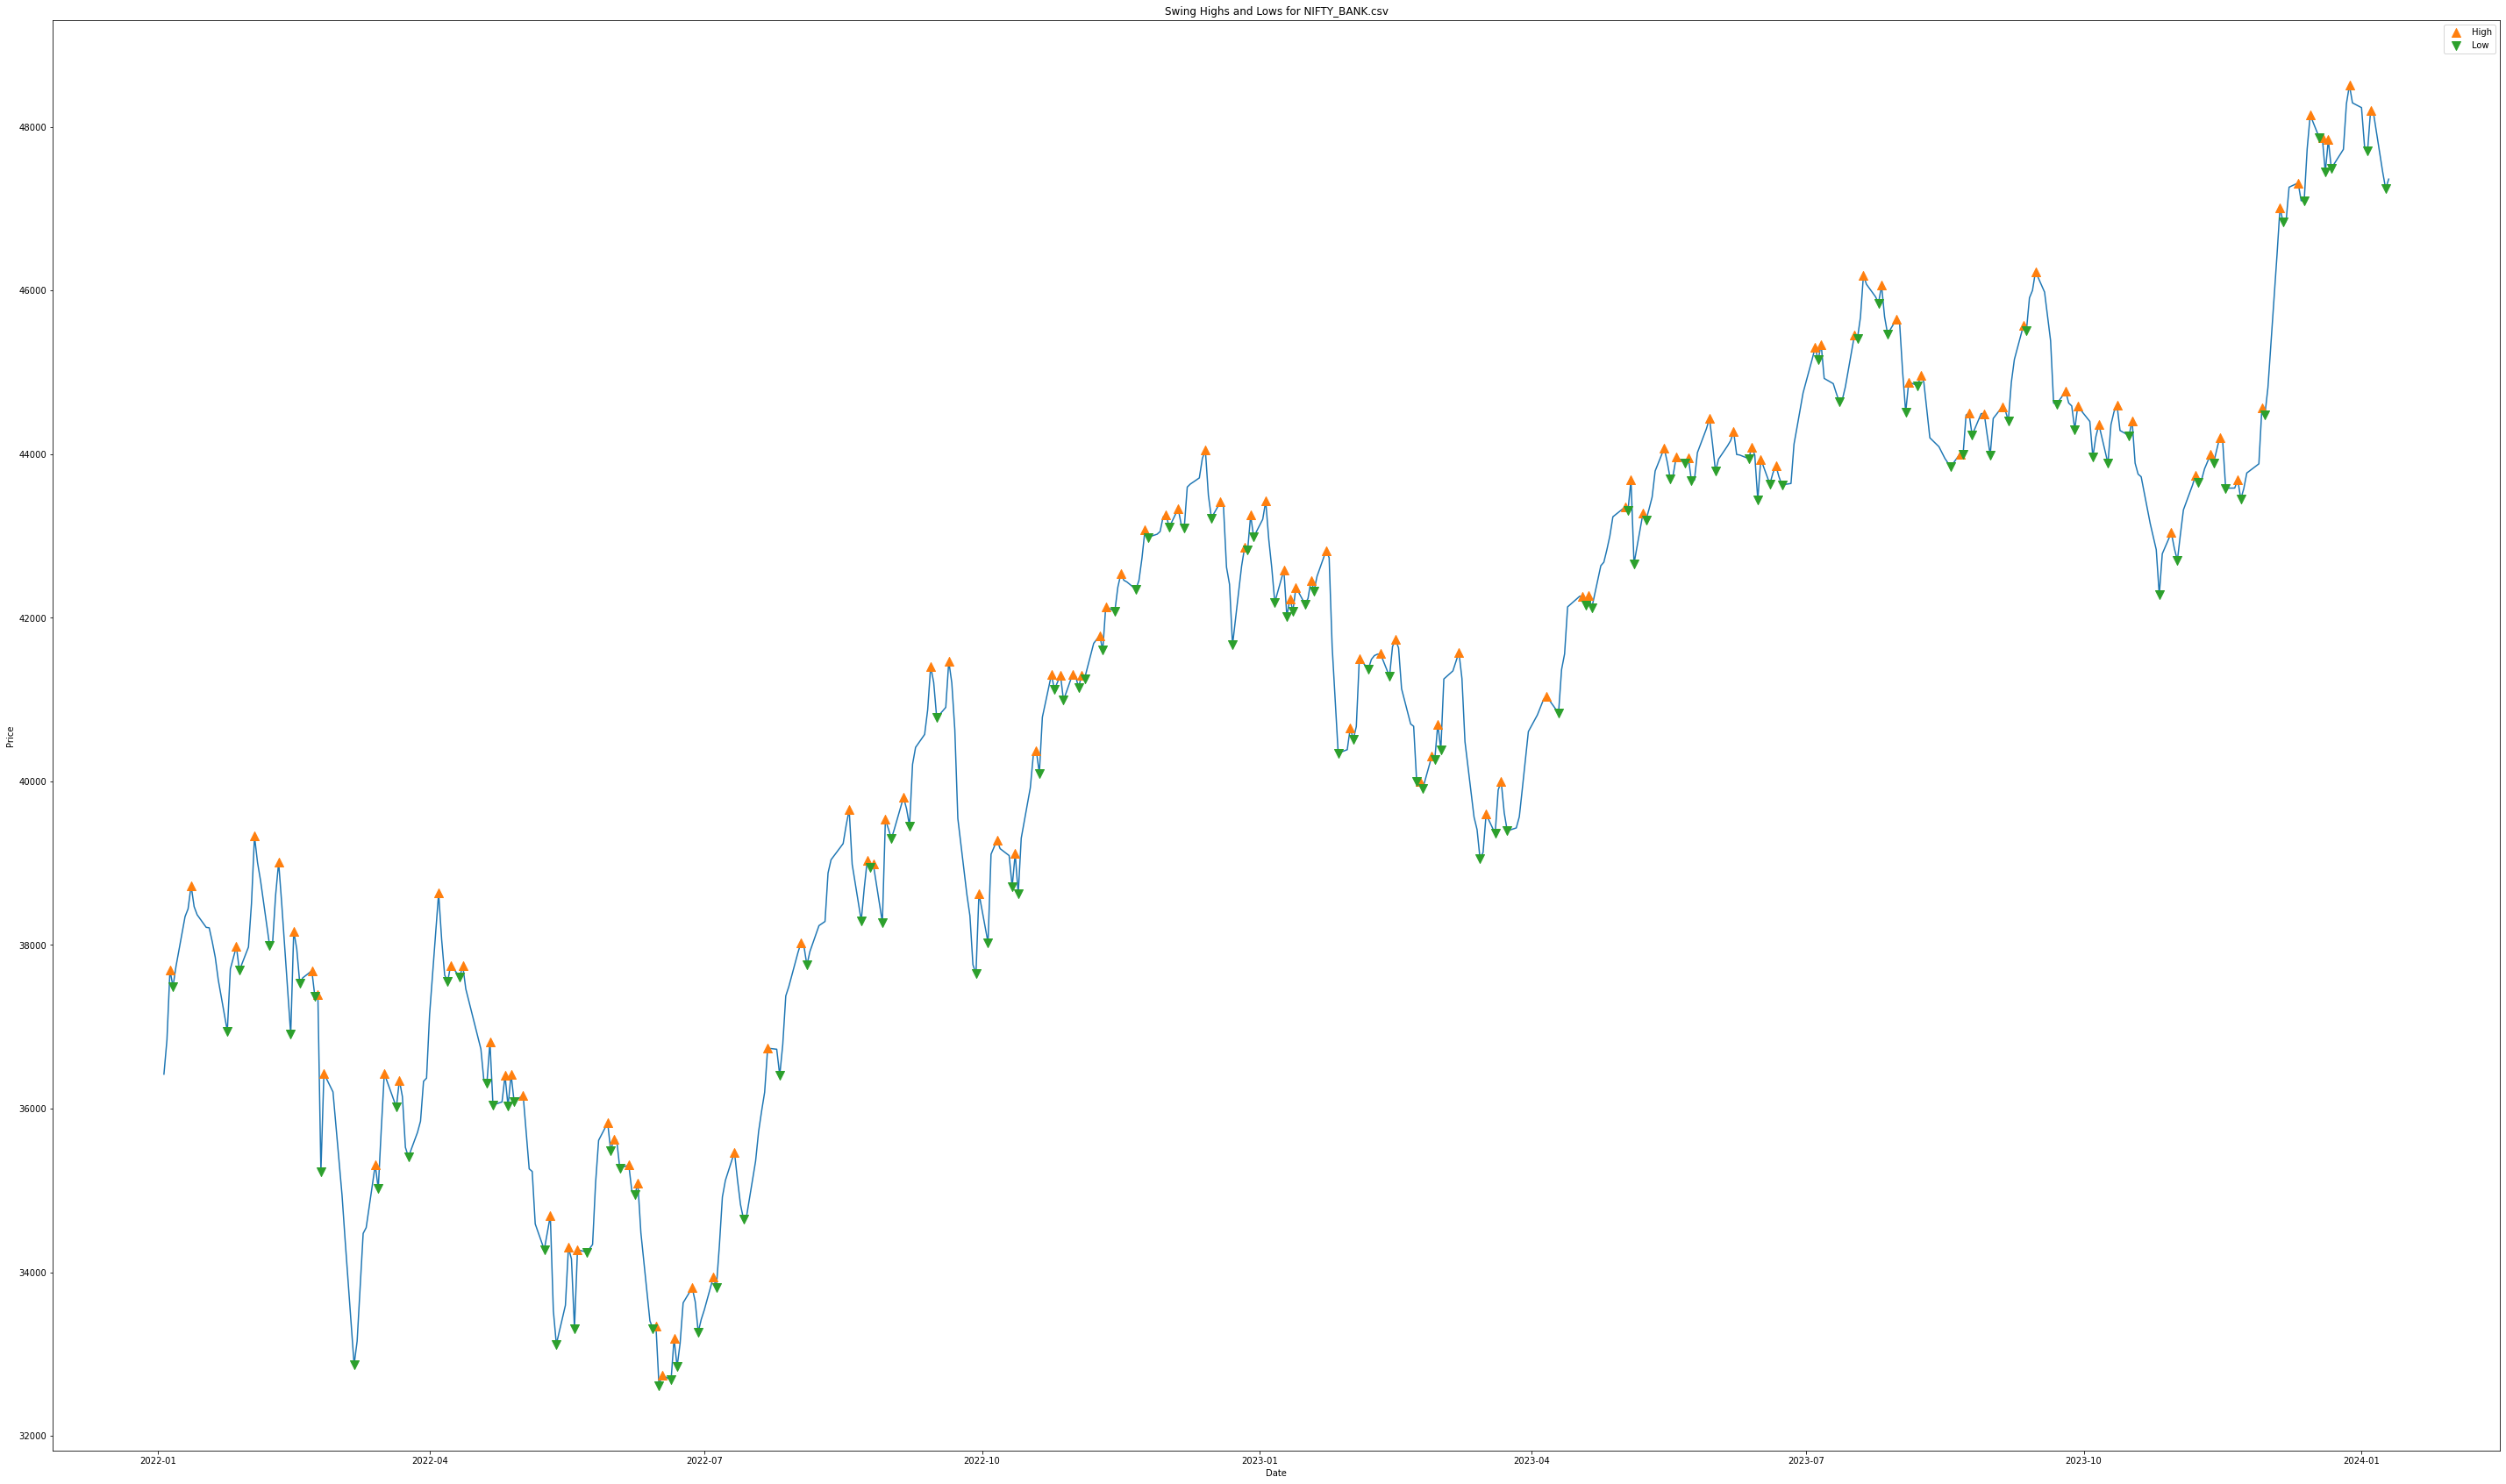

In [53]:
dt['Swing_High'] = dt['Close'][
  (dt['Close'].shift(1) < dt['Close']) &
  (dt['Close'].shift(-1) < dt['Close'])]

dt['Swing_Low'] = dt['Close'][
  (dt['Close'].shift(1) > dt['Close']) &
  (dt['Close'].shift(-1) > dt['Close'])]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(50, 30))
plt.plot(dt['Close'], zorder=0)
plt.scatter(dt.index, dt['Swing_High'], s=100,
  label='High', marker='^', c=colors[1])
plt.scatter(dt.index, dt['Swing_Low'], s=100,
  label='Low', marker='v', c=colors[2])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Swing Highs and Lows for {code}')
plt.legend()
plt.show()

In [54]:
dt.tail(10)

,Open,High,Low,Close,Swing_High,Swing_Low
2023-12-28,48479.05,48636.45,48343.15,48508.55,48508.55,NaN
2023-12-29,48374.85,48477.70,48091.85,48292.25,NaN,NaN
2024-01-01,48203.45,48450.00,48044.15,48234.30,NaN,NaN
2024-01-02,48194.80,48223.55,47689.80,47761.65,NaN,NaN
2024-01-03,47796.30,47798.75,47481.35,47704.95,NaN,47704.95
2024-01-04,47805.40,48281.20,47738.15,48195.85,48195.85,NaN
2024-01-05,48245.55,48381.95,47822.85,48159.00,NaN,NaN
2024-01-08,48096.65,48154.50,47387.35,47450.25,NaN,NaN
2024-01-09,47705.40,47939.30,47156.05,47242.65,NaN,47242.65
2024-01-10,47073.85,47423.45,47010.80,47360.85,NaN,NaN


In [55]:
dt['Swing'] = dt['Swing_High'].apply(lambda x: x if math.isnan(x) else 'SH')
dt['Dummy']=dt['Swing_Low'].apply(lambda x: 'SH' if math.isnan(x) else 'SL')
dt['Swing']=dt['Swing'].where(dt['Dummy']!='SL',dt['Dummy'])
dt=dt.drop('Dummy',axis=1)

In [56]:
dt=dt.drop(['Swing_High','Swing_Low'],axis=1)
dt.tail(10)

,Open,High,Low,Close,Swing
2023-12-28,48479.05,48636.45,48343.15,48508.55,SH
2023-12-29,48374.85,48477.70,48091.85,48292.25,NaN
2024-01-01,48203.45,48450.00,48044.15,48234.30,NaN
2024-01-02,48194.80,48223.55,47689.80,47761.65,NaN
2024-01-03,47796.30,47798.75,47481.35,47704.95,SL
2024-01-04,47805.40,48281.20,47738.15,48195.85,SH
2024-01-05,48245.55,48381.95,47822.85,48159.00,NaN
2024-01-08,48096.65,48154.50,47387.35,47450.25,NaN
2024-01-09,47705.40,47939.30,47156.05,47242.65,SL
2024-01-10,47073.85,47423.45,47010.80,47360.85,NaN


In [57]:
long_price=0
long_date=0
long_entry_price=0
long_stop_price=0
system_low=0
long_position=0
long_exit_date=0
long_exit_price=0
lp=0                            #Copy of long_price
sl=0                            #Copy of system_low
SL_cnt=0 

long_trades=[]
long_trail=[]

short_price=0
short_date=0
short_entry_price=0
short_stop_price=0
system_high=0
short_position=0
short_exit_date=0
short_exit_price=0
sp=0                            #Copy of short_price
sh=0                            #Copy of system_high
SH_cnt=0  

short_trades=[]
short_trail=[]

long_position=None
short_position=None


for i in range(len(dt)):
    
    #Long Entry Point
    if dt.Swing.iloc[i] == 'SH':
        long_price = dt.Close.iloc[i]
        system_high = dt.Close.iloc[i]
    
    #Short Entry Point
    if dt.Swing.iloc[i] == 'SL':
        short_price = dt.Close.iloc[i]
        system_low = dt.Close.iloc[i]
        #print(short_price)
        #print(i)
    
    #Long Entry Trigger
    if dt.Swing.iloc[i] != 'SH' and long_price!=0 and long_position==None:
        if dt.Close.iloc[i] > long_price:
            long_entry_price=dt.Close.iloc[i]
            long_date=dt.index[i]
            long_stop_price=long_stop(long_price,system_low)
            sl=system_low
            lp=long_price
            long_position=True
    
    #Long Stops
    if long_position == True:
        if dt.Open.iloc[i] <= sl*0.98 or dt.Open.iloc[i] <= dt.Close.iloc[i]*0.98:
            long_exit_date=dt.index[i]
            long_exit_price=dt.Open.iloc[i]
        elif dt.Close.iloc[i] <= long_stop_price:
            long_exit_date=dt.index[i]
            long_exit_price=long_stop_price
        elif dt.Swing.iloc[i] == 'SL':
            long_stop_price=dt.Close.iloc[i]
            SL_cnt=SL_cnt+1
        elif dt.Close.iloc[i] >= lp*1.02 and SL_cnt==0:
            long_stop_price=long_entry_price
        
        #To handle situations when Swing Low is formed before below long_entry_price and above stop_loss.
        #If market moves up here from these points the below code will help follow the 2% Break Even Rule
        if dt.Swing.iloc[i] == 'SL' and dt.Close.iloc[i] < lp:
            SL_cnt=0
        
        long_trail.append({'Date':dt.index[i],'Long Stop':long_stop_price})
        
    #Long Trade Records    
    if long_exit_price !=0:
        long_trades.append({'Trade Direction':'Long',
                        'Entry Date':long_date,
                       'Entry Price':long_entry_price,
                       'Stop': long_stop_price,
                      'Exit Price': long_exit_price,
                       'Exit Date': long_exit_date,
                      'Profit': long_exit_price - long_entry_price})    
        
        long_exit_price=0
        long_date=0
        long_entry_price=0
        long_stop_price=0
        long_exit_date=0
        long_position=None
        SL_cnt=0  
            
    #Short Entry Trigger
    if dt.Swing.iloc[i] != 'SL' and short_price != 0 and short_position == None:
        if dt.Close.iloc[i] < short_price:
            short_entry_price=dt.Close.iloc[i]
            short_date = dt.index[i]
            short_stop_price=short_stop(short_price,system_high)
            sh=system_high
            sp=short_price
            short_position=True
        
    #Short Stops
    if short_position == True:
        if dt.Open.iloc[i] >= sh*1.02 or dt.Open.iloc[i] >= dt.Close.iloc[i]*1.02:
            short_exit_date=dt.index[i]
            short_exit_price=dt.Open.iloc[i]
        elif dt.Close.iloc[i] >=  short_stop_price:
            short_exit_date=dt.index[i]
            short_exit_price=short_stop_price
        elif dt.Swing.iloc[i] == 'SH':
            short_stop_price = dt.Close.iloc[i]
            SH_cnt+=1
        elif dt.Close.iloc[i] <= sp*0.98 and SH_cnt==0:
            short_stop_price=short_entry_price
            
        if dt.Swing.iloc[i] == 'SH' and dt.Close.iloc[i] > sp:
            SH_cnt=0
            
                   
        short_trail.append({'Date':dt.index[i],'Short Stop':short_stop_price}) 
    
    #Short Trade Records 
    if short_exit_price !=0:
        short_trades.append({'Trade Direction':'Short',
                        'Entry Date':short_date,
                       'Entry Price':short_entry_price,
                       'Stop': short_stop_price,
                      'Exit Price': short_exit_price,
                      'Exit Date': short_exit_date,
                      'Profit': short_entry_price - short_exit_price})    
        
        short_exit_price=0
        short_date=0
        short_entry_price=0
        short_stop_price=0
        short_exit_date=0
        short_position=None
        SH_cnt=0
    

In [58]:
long_trades_df=pd.DataFrame(long_trades)
long_trail_df = pd.DataFrame(long_trail) 

long_trail_df.set_index('Date', inplace=True)
long_trades_df.set_index('Entry Date', inplace=True)

In [59]:
long_trades_df

,Trade Direction,Entry Price,Stop,Exit Price,Exit Date,Profit
Entry Date,,,,,,
2022-01-07,Long,37739.60,37739.60,37739.60,2022-01-21,0.00
2022-02-01,Long,38505.50,38505.50,38505.50,2022-02-07,0.00
2022-03-16,Long,35748.25,36018.50,36018.50,2022-03-24,270.25
2022-03-31,Long,36373.60,35621.58,36298.35,2022-04-01,-75.25
2022-05-24,Long,34290.15,35487.40,35487.40,2022-06-03,1197.25
2022-06-24,Long,33627.45,38950.75,38950.75,2022-08-29,5323.30
2022-09-08,Long,40208.95,40208.95,40308.80,2022-09-14,99.85
2022-10-04,Long,39110.05,38712.45,38712.45,2022-10-13,-397.60
2022-10-14,Long,39305.60,41122.75,41122.75,2022-10-28,1817.15


In [60]:
#long_trail_df

In [61]:
short_trades_df=pd.DataFrame(short_trades)
short_trail_df = pd.DataFrame(short_trail) 

short_trail_df.set_index('Date', inplace=True)
short_trades_df.set_index('Entry Date', inplace=True)

In [40]:
short_trades_df

,Trade Direction,Short Entry Price,Stop,Exit Price,Exit Date,Profit
Entry Date,,,,,,
2022-03-03,Short,34944.30,34944.30,34944.30,2022-03-14,0.00
2022-03-24,Short,35527.10,36348.55,36348.55,2022-03-31,-821.45
2022-04-13,Short,37463.40,36404.80,36404.80,2022-04-28,1058.60
2022-05-04,Short,35264.55,36163.75,36266.15,2022-05-04,-1001.60
2022-05-05,Short,35232.85,34693.15,34289.10,2022-05-12,943.75
2022-06-07,Short,34996.00,33339.00,33648.80,2022-06-16,1347.20
2022-09-22,Short,40630.60,41468.30,40429.35,2022-09-23,201.25
2022-09-26,Short,38616.25,38616.25,38616.25,2022-09-30,0.00
2022-12-21,Short,42617.95,43413.75,43525.75,2022-12-21,-907.80


In [62]:
#short_trail_df

In [63]:
dt = dt.merge(long_trades_df[['Entry Price']], left_index=True, right_index=True, how='left') \
          .merge(long_trail_df[['Long Stop']], left_index=True, right_index=True, how='left')

In [64]:
dt = dt.merge(short_trades_df[['Entry Price']], left_index=True, right_index=True, how='left') \
          .merge(short_trail_df[['Short Stop']], left_index=True, right_index=True, how='left')

In [65]:
dt.tail(150)

,Open,High,Low,Close,Swing,Entry Price_x,Long Stop,Entry Price_y,Short Stop
2023-06-06,44156.70,44236.20,44009.70,44164.55,NaN,NaN,43790.20,NaN,NaN
2023-06-07,44318.70,44346.30,44143.50,44275.30,SH,NaN,43790.20,NaN,NaN
2023-06-08,44208.30,44459.25,43917.90,43995.25,NaN,NaN,43790.20,NaN,NaN
2023-06-09,44045.75,44220.10,43932.60,43989.00,NaN,NaN,43790.20,NaN,NaN
2023-06-12,44035.20,44124.95,43874.05,43944.20,SL,NaN,43944.20,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-01-04,47805.40,48281.20,47738.15,48195.85,SH,NaN,47704.95,NaN,NaN
2024-01-05,48245.55,48381.95,47822.85,48159.00,NaN,NaN,47704.95,NaN,NaN
2024-01-08,48096.65,48154.50,47387.35,47450.25,NaN,NaN,47704.95,NaN,48195.85
2024-01-09,47705.40,47939.30,47156.05,47242.65,SL,NaN,NaN,NaN,48195.85


In [66]:
bt=pd.merge(short_trades_df.reset_index(),long_trades_df.reset_index(),how='outer')
bt=bt.set_index('Entry Date')
bt=bt.sort_index(axis=0)
bt.tail()

,Trade Direction,Entry Price,Stop,Exit Price,Exit Date,Profit
Entry Date,,,,,,
2023-10-11,Long,44516.90,44225.90,44225.90,2023-10-18,-291.00
2023-10-18,Short,43888.70,43039.15,43039.15,2023-11-03,849.55
2023-11-03,Long,43318.25,43891.25,43891.25,2023-11-17,573.00
2023-11-24,Long,43769.10,47867.70,47867.70,2023-12-20,4098.60
2023-12-27,Long,48282.20,47704.95,47704.95,2024-01-08,-577.25


In [67]:
#Multiplying the Points gained/Lost with Bank Nifty Futures Lot Size, 
#Premium aka Cost of Carry has not been considered!!!
bt['Profit']=bt['Profit'].apply(lambda x:x*15) 

In [68]:
bt.tail()

,Trade Direction,Entry Price,Stop,Exit Price,Exit Date,Profit
Entry Date,,,,,,
2023-10-11,Long,44516.90,44225.90,44225.90,2023-10-18,-4365.00
2023-10-18,Short,43888.70,43039.15,43039.15,2023-11-03,12743.25
2023-11-03,Long,43318.25,43891.25,43891.25,2023-11-17,8595.00
2023-11-24,Long,43769.10,47867.70,47867.70,2023-12-20,61479.00
2023-12-27,Long,48282.20,47704.95,47704.95,2024-01-08,-8658.75


In [69]:
bt['DD']=np.where(bt.Profit.iloc[0]<0,bt.Profit.iloc[0],0)
for i in range(1,len(bt)):
    if bt.Profit.iloc[i] + bt.DD.iloc[i-1] < 0:
        bt.DD.iloc[i]=bt.Profit.iloc[i] + bt.DD.iloc[i-1]
    else:
        bt.DD.iloc[i]=0
bt.head()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Trade Direction,Entry Price,Stop,Exit Price,Exit Date,Profit,DD
Entry Date,,,,,,,
2022-01-07,Long,37739.60,37739.60,37739.60,2022-01-21,0.00,0.00
2022-02-01,Long,38505.50,38505.50,38505.50,2022-02-07,0.00,0.00
2022-03-03,Short,34944.30,34944.30,34944.30,2022-03-14,0.00,0.00
2022-03-16,Long,35748.25,36018.50,36018.50,2022-03-24,4053.75,0.00
2022-03-24,Short,35527.10,36348.55,36348.55,2022-03-31,-12321.75,-12321.75


In [70]:
bt.loc['Cumulative Profit'] = pd.Series(bt['Profit'].sum(), index=['Profit'])
bt.loc['Max DD'] = pd.Series(bt['DD'].min(), index=['DD'])
bt.loc['Margin']=pd.Series(100000,index=['Profit'])
bt.loc['Profit Per Anum']=pd.Series(bt.loc['Cumulative Profit','Profit']/2,index=['Profit'])
bt.loc['Return Perc']=pd.Series((bt.loc['Profit Per Anum','Profit']/bt.loc['Margin','Profit'])*100,index=['Profit'])
bt.loc['Calmer']=pd.Series(bt.loc['Profit Per Anum','Profit']/abs(bt.loc['Max DD','DD']),index=['Profit'])

In [71]:
print(bt)

                  Trade Direction  Entry Price      Stop  Exit Price  \
Entry Date                                                             
2022-01-07                   Long     37739.60  37739.60    37739.60   
2022-02-01                   Long     38505.50  38505.50    38505.50   
2022-03-03                  Short     34944.30  34944.30    34944.30   
2022-03-16                   Long     35748.25  36018.50    36018.50   
2022-03-24                  Short     35527.10  36348.55    36348.55   
2022-03-31                   Long     36373.60  35621.58    36298.35   
2022-04-13                  Short     37463.40  36404.80    36404.80   
2022-05-04                  Short     35264.55  36163.75    36266.15   
2022-05-05                  Short     35232.85  34693.15    34289.10   
2022-05-24                   Long     34290.15  35487.40    35487.40   
2022-06-07                  Short     34996.00  33339.00    33648.80   
2022-06-24                   Long     33627.45  38950.75    3895

In [72]:
bt.to_csv('Backtest_Res.csv')